# Modeling

In this notebook, we will be running models to predict whether a company goes bankrupt.  We will quickly preprocess the data, and then move on to modeling.

## Imports

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score

In [128]:
df = pd.read_csv('../data/nooutlier_EDA.csv', index_col=False)
df.shape

(4909, 95)

## Preprocess Data

In [129]:
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

scaler = StandardScaler()
X = scaler.fit_transform(X)

oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, stratify=y)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=.33)

As the baseline, we will use logistic regression, as well as a dummy classifier to see what score we should be looking to beat

In [130]:
param_dict = {"penalty": ['l2', 'elasticnet','none'],
            "C": [0,.25,.5,.75,1],
            "warm_start":[True, False],
            "l1_ratio":[np.linspace(0,1,4)]}

lg = LogisticRegression()
lg_cv = GridSearchCV(lg, param_grid=param_dict, cv=5)

best_model_base = lg_cv.fit(X_train, y_train)
filename = 'best_model_base.sav'
pickle.dump(best_model_base,open(filename, 'wb'))

best_model_smote = lg_cv.fit(X_train_smote, y_train_smote)
filename = 'best_model_smote.sav'
pickle.dump(best_model_smote,open(filename, 'wb'))

In [131]:
dfresults = pd.DataFrame()

#load unbalanced original nooutliers model
filename = 'best_model_base.sav'
base_model = pickle.load(open(filename, 'rb'))

y_pred = base_model.predict(X_test)
#Check how well model generalizes
y_train_pred_base = base_model.predict(X_train)
train_ac_base = accuracy_score(y_train, y_train_pred_base)
train_f1_base = f1_score(y_train, y_train_pred_base, average='weighted')
train_recall_base = recall_score(y_train, y_train_pred_base)

#dummy classifier
dummy_score_dict = {}
strategies = ['stratified', 'most_frequent', 'uniform']
for strategy in strategies:
        dclf = DummyClassifier(strategy=strategy)
        dclf.fit(X_train, y_train)
        dummy_score = dclf.score(X_test, y_test)
        dummy_score_dict[strategy] = dummy_score
dummy_df = pd.DataFrame.from_dict(dummy_score_dict, orient='index', columns=['score'])

#base model scoring metrics
ac_base = accuracy_score(y_test, y_pred)
f1_base = f1_score(y_test, y_pred, average='weighted')
balanced_ac_base = balanced_accuracy_score(y_test, y_pred)
recall_base = recall_score(y_test, y_pred)
base_class_report = classification_report(y_test, y_pred)
base_best_classifier = base_model.best_estimator_.get_params()

#adding base model scoring metrics to dataframe
results = pd.DataFrame({"Train Accuracy": train_ac_base, "Test Accuracy": ac_base, "Balanced Accuracy": balanced_ac_base, "Train F1":train_f1_base, "Test F1" : f1_base, 'Train Recall Score': train_recall_base, "Test Recall Score": recall_base}, index=["original"])
dfresults = dfresults.append(results)


#load smote model
filename = 'best_model_smote.sav'
smote_model = pickle.load(open(filename, 'rb'))

y_pred_smote = smote_model.predict(X_test_smote)

cv_results_smote = pd.DataFrame(smote_model.cv_results_)
cv_results_smote = cv_results_smote.sort_values(by=['rank_test_score'])
cv_results_smote[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
    ]
#Check how well model generalizes
y_train_pred_smote = smote_model.predict(X_train_smote)
train_ac_smote = accuracy_score(y_train_smote, y_train_pred_smote)
train_f1_smote = f1_score(y_train_smote, y_train_pred_smote, average='weighted')
train_recall_smote = recall_score(y_train_smote, y_train_pred_smote)

#smote scoring metrics
ac_smote = accuracy_score(y_test_smote, y_pred_smote)
f1_smote = f1_score(y_test_smote, y_pred_smote, average='weighted')
balanced_ac_smote = balanced_accuracy_score(y_test_smote, y_pred_smote)
recall_smote = recall_score(y_test_smote, y_pred_smote)
smote_class_report = classification_report(y_test_smote, y_pred_smote)
smote_best_classifier = smote_model.best_estimator_.get_params()

results = pd.DataFrame({"Train Accuracy": train_ac_smote, "Test Accuracy": ac_smote, "Balanced Accuracy": balanced_ac_smote, "Train F1":train_f1_smote, "Test F1" : f1_smote, 'Train Recall Score': train_recall_smote, "Test Recall Score": recall_smote}, index=['SMOTE'])

print("Cross-validation base model mean test score:", cv_results_base.iloc[0]['mean_test_score'])
cv_results_base.head()

print("Cross-validation SMOTE mean test score:", cv_results_smote.iloc[0]['mean_test_score'])
cv_results_smote.head()
dfresults = dfresults.append(results)
print('\n--------------------------------\n')
print('Dummy classifier')
print(dummy_df)
print('\n--------------------------------\n')
print('Comparison of unbalanced vs SMOTE models')
print(dfresults)
print('\n--------------------------------\n')
print('Unbalanced Classification Report')
print(base_class_report)
print('\n--------------------------------\n')
print('SMOTE Classification report')
print(smote_class_report)




Cross-validation base model mean test score: 0.9750667351366855
Cross-validation SMOTE mean test score: 0.9267684530270032

--------------------------------

Dummy classifier
               score
stratified      0.96
most_frequent   0.98
uniform         0.50

--------------------------------

Comparison of unbalanced vs SMOTE models
          Train Accuracy  Test Accuracy  Balanced Accuracy  Train F1  Test F1  \
original            0.98           0.97               0.61      0.97     0.97   
SMOTE               0.93           0.91               0.91      0.93     0.91   

          Train Recall Score  Test Recall Score  
original                0.24               0.23  
SMOTE                   0.96               0.95  

--------------------------------

Unbalanced Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1581
           1       0.45      0.23      0.31        39

    accuracy                           

As we can see, although the accuracy of the original dataset is high at around 98%, it is not actually capturing the target that we want.  The companies going bankrupt has an recall score of 23%.   The SMOTE model does slightly worse with classifying the 'not bankrupt' class, but vastly improves the accuracy of the 'bankrupt' class.   We are still looking to beat the dummy classifier of just picking the most frequent value, at 97%. We will continue looking for a classifier that does better than this baseline.  As we want to limit the number of false negatives, recall will be chosen as the metric.  This ensures that while more companies may be labeled as going bankrupt that don't, it will limit the number of companies that go bankrupt that aren't classified as bankrupt

# Model Search

Now that we have a baseline of logistic regression on our unbalanced and SMOTE balanced dataset, we will use a library to run a multitude of lazy classifiers to see which ones we should investigate further to beat the logistic regression baseline.


In [132]:
from sklearn.metrics import recall_score, accuracy_score
from sklearn.metrics import recall_score, accuracy_score

lazy_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=recall_score)
models, predictions = lazy_clf.fit(X_train_smote, X_test_smote, y_train_smote, y_test_smote)

print(models)

100%|██████████| 29/29 [00:39<00:00,  1.38s/it]                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.99               0.99     0.99      0.99   
LGBMClassifier                     0.99               0.99     0.99      0.99   
XGBClassifier                      0.99               0.99     0.99      0.99   
RandomForestClassifier             0.98               0.98     0.98      0.98   
BaggingClassifier                  0.98               0.98     0.98      0.98   
LabelPropagation                   0.98               0.98     0.98      0.98   
LabelSpreading                     0.98               0.98     0.98      0.98   
SVC                                0.98               0.98     0.98      0.98   
DecisionTreeClassifier             0.96               0.96     0.96      0.96   
AdaBoostClassifier                 0.96               0.96    

## From our lazy classifier, we see that ExtraTreesClassifier, LGBMClassifier, RandomForestClassifier, and XGBClassifier all have high recall, so we will be investigating them to see if we can outperform the dummy classifier at 97%

This is an initial test of the models before hyperparameter tuning

ExtraTreeClassifier
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1602
           1       0.97      1.00      0.99      1560

    accuracy                           0.99      3162
   macro avg       0.99      0.99      0.99      3162
weighted avg       0.99      0.99      0.99      3162



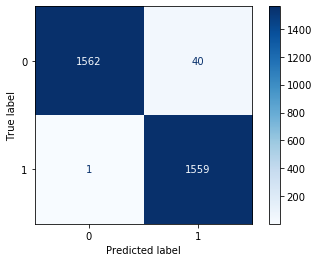


-------------------------

RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1602
           1       0.97      1.00      0.98      1560

    accuracy                           0.98      3162
   macro avg       0.98      0.98      0.98      3162
weighted avg       0.98      0.98      0.98      3162



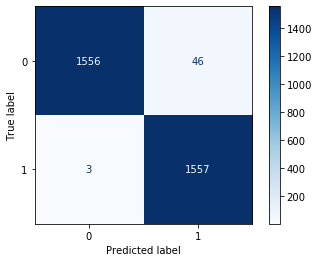


-------------------------

LGBMClassifier
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1602
           1       0.98      1.00      0.99      1560

    accuracy                           0.99      3162
   macro avg       0.99      0.99      0.99      3162
weighted avg       0.99      0.99      0.99      3162



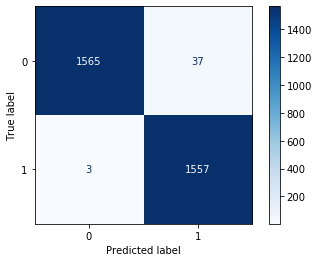


-------------------------

XGBClassifier
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1602
           1       0.98      1.00      0.99      1560

    accuracy                           0.99      3162
   macro avg       0.99      0.99      0.99      3162
weighted avg       0.99      0.99      0.99      3162



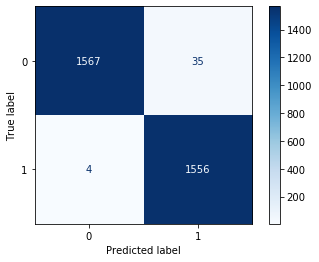


-------------------------

                        Train Accuracy  Test Accuracy  Balanced Accuracy  \
ExtraTreeClassifier               1.00           0.99               0.99   
RandomForestClassifier            1.00           0.98               0.98   
LGBMClassifier                    1.00           0.99               0.99   
XGBClassifier                     1.00           0.99               0.99   

                        Train F1  Test F1  
ExtraTreeClassifier         1.00     0.99  
RandomForestClassifier      1.00     0.98  
LGBMClassifier              1.00     0.99  
XGBClassifier               1.00     0.99  


In [152]:
dfresults = pd.DataFrame()
class_report = pd.DataFrame()
models = {"ExtraTreeClassifier": ExtraTreesClassifier(),
            "RandomForestClassifier": RandomForestClassifier(),
            "LGBMClassifier": LGBMClassifier(),
            "XGBClassifier": XGBClassifier()}
for key, model in models.items():
    fit_model = model.fit(X_train_smote, y_train_smote)
    y_pred_smote = fit_model.predict(X_test_smote)
    
    #Check how well model generalizes
    y_train_pred_smote = model.predict(X_train_smote)
    train_ac_smote = accuracy_score(y_train_smote, y_train_pred_smote)
    train_f1_smote = f1_score(y_train_smote, y_train_pred_smote, average='weighted')

    ac_smote = accuracy_score(y_test_smote, y_pred_smote)
    f1_smote = f1_score(y_test_smote, y_pred_smote, average='weighted')
    balanced_ac_smote = balanced_accuracy_score(y_test_smote, y_pred_smote)
    key_class = "{mod}_class_report".format(mod=key)
    key_class = classification_report(y_test_smote, y_pred_smote)
    results = pd.DataFrame({"Train Accuracy": train_ac_smote, "Test Accuracy": ac_smote,"Balanced Accuracy": balanced_ac_smote, "Train F1":train_f1_smote, "Test F1" :f1_smote}, index=[key])
    dfresults = dfresults.append(results)
    print(key)
    print(key_class)
    plot_confusion_matrix(model, X_test_smote, y_test_smote, cmap='Blues')
    plt.show()
    print("\n-------------------------\n")
print(dfresults)

Without any hyperparameter tuning, we can confidently choose the ExtraTreeClassifier, as it allowed 1 bankrupt companies to slip through without being labeled correctly, although any would be a great choice.  We will now do some feature removal to see if we can get the same prediction with less features.  This allows for a model that is less computationally expensive

In [120]:
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

sel = SelectFromModel(RandomForestClassifier(random_state=42))
sel.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(random_state=42))

In [121]:
features = X.columns[(sel.get_support())]
print(len(features))
features

34


Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(B) before interest and depreciation after tax',
       ' non-industry income and expenditure/revenue',
       ' continuous interest rate (after tax)', ' operating expense rate',
       ' interest-bearing debt interest rate', ' per Net Share Value (B)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Per Share Net profit before tax (yuan)', ' net value growth rate',
       ' quick ratio', ' interest expense ratio',
       ' total debt/total net worth', ' debt ratio %', ' net worth/assets',
       ' borrowing dependency', ' net profit before tax/paid-in capital',
       ' accounts receivable turnover', ' average collection days',
       ' fixed assets Turnover frequency', ' working capital to total assets',
       'cash / total assets', 'cash / current liability',
       'Inventory/working capital', 'working capital/equity',
       'current liability/equity', 'net incom

### Number of features removed

In [122]:
X.shape[1]-(len(features))

60

## Reprocessing Data

In [123]:
X[features]

,ROA(C) before interest and depreciation before interest,ROA(B) before interest and depreciation after tax,non-industry income and expenditure/revenue,continuous interest rate (after tax),operating expense rate,interest-bearing debt interest rate,per Net Share Value (B),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Per Share Net profit before tax (yuan),...,Inventory/working capital,working capital/equity,current liability/equity,net income to total assets,total assets to GNP price,Net income to stockholder's Equity,liability to equity,Degree of financial leverage (DFL),Interest coverage ratio( Interest expense to EBIT ),equity to liability
0,0.37,0.41,0.30,0.78,0.00,0.00,0.15,0.15,0.17,0.14,...,0.28,0.72,0.34,0.72,0.01,0.83,0.29,0.03,0.56,0.02
1,0.47,0.52,0.30,0.78,7890000000.00,0.00,0.17,0.17,0.21,0.17,...,0.29,0.73,0.33,0.80,0.00,0.84,0.28,0.02,0.58,0.04
2,0.39,0.44,0.30,0.78,0.00,0.00,0.16,0.16,0.16,0.13,...,0.28,0.73,0.34,0.74,0.02,0.83,0.29,0.03,0.56,0.02
3,0.51,0.56,0.30,0.78,9000000000.00,0.00,0.18,0.18,0.23,0.18,...,0.28,0.73,0.33,0.82,0.01,0.84,0.28,0.03,0.57,0.03
4,0.49,0.54,0.30,0.78,0.00,0.00,0.18,0.18,0.22,0.17,...,0.28,0.74,0.33,0.80,0.00,0.84,0.28,0.03,0.57,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904,0.49,0.54,0.30,0.78,0.00,0.00,0.17,0.17,0.22,0.17,...,0.28,0.74,0.33,0.81,0.00,0.84,0.28,0.03,0.57,0.06
4905,0.48,0.53,0.30,0.78,0.00,0.00,0.18,0.18,0.21,0.17,...,0.29,0.73,0.33,0.79,0.00,0.84,0.28,0.02,0.57,0.02
4906,0.49,0.54,0.30,0.78,0.00,0.00,0.18,0.18,0.22,0.17,...,0.28,0.74,0.33,0.80,0.00,0.84,0.28,0.03,0.57,0.03
4907,0.48,0.52,0.30,0.78,5220000000.00,0.00,0.18,0.18,0.22,0.17,...,0.28,0.73,0.33,0.80,0.00,0.84,0.28,0.03,0.57,0.04


In [124]:
X = X[features]
y = df['Bankrupt?']

In [125]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, stratify=y)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=.33)

ExtraTreeClassifier
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1565
           1       0.98      1.00      0.99      1597

    accuracy                           0.99      3162
   macro avg       0.99      0.99      0.99      3162
weighted avg       0.99      0.99      0.99      3162



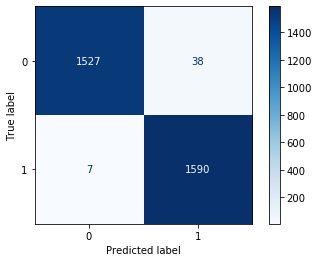


-------------------------

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1565
           1       0.97      0.99      0.98      1597

    accuracy                           0.98      3162
   macro avg       0.98      0.98      0.98      3162
weighted avg       0.98      0.98      0.98      3162



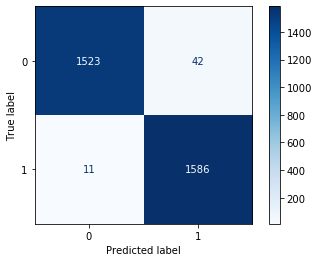


-------------------------

LGBMClassifier
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1565
           1       0.97      1.00      0.98      1597

    accuracy                           0.98      3162
   macro avg       0.98      0.98      0.98      3162
weighted avg       0.98      0.98      0.98      3162



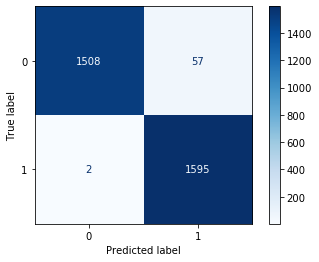


-------------------------

XGBClassifier
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1565
           1       0.97      1.00      0.98      1597

    accuracy                           0.98      3162
   macro avg       0.99      0.98      0.98      3162
weighted avg       0.98      0.98      0.98      3162



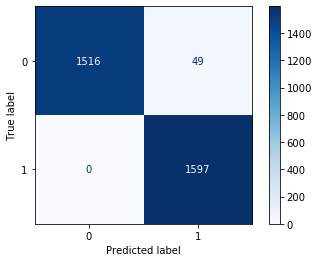


-------------------------

                        Train Accuracy  Test Accuracy  Balanced Accuracy  \
ExtraTreeClassifier               1.00           0.99               0.99   
RandomForestClassifier            1.00           0.98               0.98   
LGBMClassifier                    1.00           0.98               0.98   
XGBClassifier                     1.00           0.98               0.98   

                        Train F1  Test F1  
ExtraTreeClassifier         1.00     0.99  
RandomForestClassifier      1.00     0.98  
LGBMClassifier              1.00     0.98  
XGBClassifier               1.00     0.98  


In [126]:
dfresults = pd.DataFrame()
class_report = pd.DataFrame()
models = {"ExtraTreeClassifier": ExtraTreesClassifier(),
            "RandomForestClassifier": RandomForestClassifier(),
            "LGBMClassifier": LGBMClassifier(),
            "XGBClassifier": XGBClassifier()}
for key, model in models.items():
    fit_model = model.fit(X_train_smote, y_train_smote)
    y_pred_smote = fit_model.predict(X_test_smote)
    
    #Check how well model generalizes
    y_train_pred_smote = model.predict(X_train_smote)
    train_ac_smote = accuracy_score(y_train_smote, y_train_pred_smote)
    train_f1_smote = f1_score(y_train_smote, y_train_pred_smote, average='weighted')

    ac_smote = accuracy_score(y_test_smote, y_pred_smote)
    f1_smote = f1_score(y_test_smote, y_pred_smote, average='weighted')
    balanced_ac_smote = balanced_accuracy_score(y_test_smote, y_pred_smote)
    key_class = "{mod}_class_report".format(mod=key)
    key_class = classification_report(y_test_smote, y_pred_smote)
    results = pd.DataFrame({"Train Accuracy": train_ac_smote, "Test Accuracy": ac_smote,        "Balanced Accuracy": balanced_ac_smote, "Train F1":train_f1_smote, "Test F1" :              f1_smote}, index=[key])
    dfresults = dfresults.append(results)
    print(key)
    print(key_class)
    plot_confusion_matrix(model, X_test_smote, y_test_smote, cmap='Blues')
    plt.show()
    print("\n-------------------------\n")
print(dfresults)

With the reduction of 60 of the 94 features, we have a slight reduction in the recall of the various models.  Now, with the XGB Classifier, we have the best recall of all models tested.  If the reduction of computational cost is worth the possible differences in recall, feature reduction can be incorporated into predicting any new data